In [1]:
import os, sys
currentdir = os.path.dirname(os.getcwd())
sys.path.append(currentdir)

import yaml
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from matplotlib import pyplot as plt
import math

from utils import preprocessing as pre
from utils import models_new
from utils.callbacks import coef_det_k
import matplotlib.pyplot as plt

In [10]:
# Data loading

dir_ = '/mnt/Archive/Data_Sets/OGT/ogt_classes'

names_class = ['ogt_4_15.fasta', 'ogt_26_37.fasta', 'ogt_48_59.fasta', 'ogt_70_81.fasta']
names_reg = ['ogt_4_15.fasta', 'ogt_15_26.fasta', 'ogt_26_37.fasta', 'ogt_37_48.fasta', 'ogt_48_59.fasta', 'ogt_59_70.fasta', 'ogt_70_81.fasta']

dir_ = '../data/OGT_Classes'

names_reg = ['ogt_all.fasta']

dataset_train, data_val = pre.prepare_dataset_reg(dir_, names_reg,
                               seq_length = 512,
                               t_v_split = 0.1,
                               max_samples = 400000)

ogt_all.fasta 141668


In [4]:
for i, item in enumerate(data_train):
    pass
print(item)

(<tf.Tensor: shape=(512, 21), dtype=float32, numpy=
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>, <tf.Tensor: shape=(), dtype=float32, numpy=-4.9>)


In [3]:
def coef_det_k(y_true, y_pred):
    """Computer coefficient of determination R^2
    """
    SS_res = K.sum(K.square(y_true - y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return 1 - SS_res / (SS_tot + K.epsilon())

In [4]:
# model define

filters = [64, 64, 64, 128, 128, 128, 256, 256, 256]
sizes   = [6, 6, 6, 6, 6, 6, 4, 4, 4]
dilation= [1, 1, 1, 1, 1, 1, 1, 1, 1]
strides = [1, 2, 1, 2, 1, 2, 1, 2, 1]
vocab   = 21


opt = keras.optimizers.Adam(learning_rate=0.0001)
loss = tf.keras.losses.CategoricalCrossentropy(
    from_logits=False, label_smoothing=0,
    name='categorical_crossentropy'
)
acc = tf.keras.metrics.CategoricalAccuracy(
    name='categorical_accuracy', dtype=None
)


model = models_new.Classifier(filters, sizes, strides, dilation, vocab)

model.compile(optimizer=opt, loss='mse', metrics=[coef_det_k])
model.summary()



Model: "classifier_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 512, 21)]         0         
_________________________________________________________________
res_mod (ResMod)             (None, 512, 64)           58560     
_________________________________________________________________
res_mod_1 (ResMod)           (None, 256, 64)           102400    
_________________________________________________________________
res_mod_2 (ResMod)           (None, 256, 64)           77824     
_________________________________________________________________
res_mod_3 (ResMod)           (None, 128, 128)          352256    
_________________________________________________________________
res_mod_4 (ResMod)           (None, 128, 128)          311296    
_________________________________________________________________
res_mod_5 (ResMod)           (None, 64, 128)          

In [15]:
# learning rate schedule
class CustomSchedule(tf.keras.callbacks.Callback):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps
        self.k1 = (d_model - 1e-7)/warmup_steps
        self.k2 = self.k1/8
        
    def __call__(self, step, lr=0.1):
        step = step*31500/32
        arg1 = self.k1*step + 1e-7
        arg2 = self.d_model - self.k1*step
        arg3 = self.d_model*1/4 -self.k2*step
        return tf.math.minimum(arg1, tf.math.maximum(arg2,arg3))

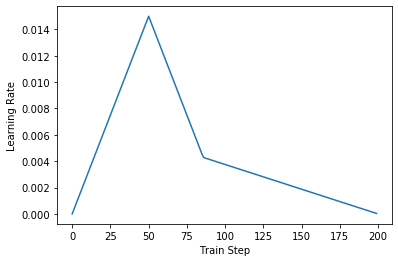

In [21]:
epochs = 200
steps = epochs *  31500/32
lr_schedule = CustomSchedule(0.03, steps/2)
plt.plot(lr_schedule(tf.range(epochs, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")
plt.show()

In [ ]:
x_train = data_train.shuffle(buffer_size = 50000).batch(64, drop_remainder=True) 
x_val = data_val.shuffle(buffer_size = 50000).batch(64, drop_remainder=True)

epochs = 200

history = model.fit(x_train, epochs=epochs, validation_data = x_val)

Epoch 1/200
793/793 [==============================] - 27s 34ms/step - loss: 302.1821 - coef_det_k: 0.3187 - val_loss: 277.1752 - val_coef_det_k: 0.3791
Epoch 2/200
793/793 [==============================] - 26s 33ms/step - loss: 253.4169 - coef_det_k: 0.4302 - val_loss: 246.0493 - val_coef_det_k: 0.4490
Epoch 3/200
793/793 [==============================] - 26s 33ms/step - loss: 242.7021 - coef_det_k: 0.4523 - val_loss: 228.6516 - val_coef_det_k: 0.4850
Epoch 4/200
793/793 [==============================] - 26s 33ms/step - loss: 235.6452 - coef_det_k: 0.4690 - val_loss: 223.0209 - val_coef_det_k: 0.4984
Epoch 5/200
793/793 [==============================] - 26s 33ms/step - loss: 226.2336 - coef_det_k: 0.4905 - val_loss: 231.4344 - val_coef_det_k: 0.4799
Epoch 6/200
793/793 [==============================] - 26s 33ms/step - loss: 220.5133 - coef_det_k: 0.5027 - val_loss: 212.2879 - val_coef_det_k: 0.5208
Epoch 7/200
793/793 [==============================] - 26s 33ms/step - loss: 210.6

In [11]:
print(history)

<tf.Variable 'Adam/learning_rate:0' shape=() dtype=float32, numpy=1e-04>


In [10]:
model.save_weights('weights/model_ogt')

In [14]:
model.summary()

Model: "classifier_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
res_mod_6 (ResMod)           multiple                  56000     
_________________________________________________________________
res_mod_7 (ResMod)           multiple                  53376     
_________________________________________________________________
res_mod_8 (ResMod)           multiple                  237824    
_________________________________________________________________
res_mod_9 (ResMod)           multiple                  213248    
_________________________________________________________________
res_mod_10 (ResMod)          multiple                  950784    
_________________________________________________________________
res_mod_11 (ResMod)          multiple                  1114624   
_________________________________________________________________
self_attention_1 (SelfAttent multiple                 

In [14]:
import yaml

import numpy as np
import tensorflow as tf

with open("../config/config_classifier.yaml", 'r') as file_descriptor:
        config = yaml.load(file_descriptor, Loader=yaml.FullLoader)

model =  models_new.Classifier(config['Classifier'])
model.load_weights('../weights/classifier2.h5')
x_val = data_val.shuffle(buffer_size = 40000).batch(64, drop_remainder=True)
s = 0
count = 0
for i, x in enumerate(x_val):    
    out = model(x[0], training=True)
    #attention_weights = model.a_w
    #break
    for j in zip(out, x[1].numpy()):
        s += j[0][0].numpy() - j[1]
        count += 1

print(s/count)

-0.15206230082549155


In [18]:
import matplotlib.pyplot as plt
import numpy as np
import math
from Bio import SeqIO

AAS = 'ACDEFGHIKLMNPQRSTVWYX'

def import_alignment(name):
    dict_alignment_all    = {'id':[], 'ogt':[], 'seq':[]}
    dict_alignment_meso   = {'id':[], 'ogt':[], 'seq':[]}
    dict_alignment_thermo = {'id':[], 'ogt':[], 'seq':[]}

    for rec in SeqIO.parse(name, 'fasta'):
        dict_alignment_all['id'].append(rec.id)
        dict_alignment_all['ogt'].append(float(rec.description.split()[-1]))
        dict_alignment_all['seq'].append(str(rec.seq))

        if float(rec.description.split()[-1]) <= 15:
            dict_alignment_meso['id'].append(rec.id)
            dict_alignment_meso['ogt'].append(float(rec.description.split()[-1]))
            dict_alignment_meso['seq'].append(str(rec.seq))
        else:
            dict_alignment_thermo['id'].append(rec.id)
            dict_alignment_thermo['ogt'].append(float(rec.description.split()[-1]))
            dict_alignment_thermo['seq'].append(str(rec.seq))
    dict_ ={'All':dict_alignment_all, 'Meso':dict_alignment_meso, 'Thermo': dict_alignment_thermo}
    return dict_

def index_aa(seq):
    idx = []
    for i, aa in enumerate(seq):
        if aa is not "-":
            idx.append(i)
    return idx

def aa_at_index(idx, ali):
    list_mutations=[]
    for j in idx:
        tmp=[]
        for i, seq in enumerate(ali['seq']):
            tmp.append(seq[j])
        list_mutations.append(tmp)
    return list_mutations

def prob_mutation(seq, idx, msa_aa):
    total_counts_per_residue = []
    insertion_site = np.zeros((len(idx),))
    for index, res_aa in enumerate(msa_aa):
        count_residue = 1
        for aa in res_aa:
            if aa is not '-':
                count_residue += 1
        total_counts_per_residue.append(count_residue)
        if all(np.array(res_aa) == '-'):
            insertion_site[index] = 1
    
    same_counts_per_residue = []
    for i, res_aa in enumerate(msa_aa):
        count_residue = 1
        for aa in res_aa:
            if aa is seq[idx[i]]:
                count_residue += 1
        same_counts_per_residue.append(count_residue)
   
    return np.array(same_counts_per_residue)/np.array(total_counts_per_residue), insertion_site

def residy_entropy(seq, idx, msa_aa):
    total_counts_per_residue = []
    insertion_site = np.zeros((len(idx),))
    for index, res_aa in enumerate(msa_aa):
        count_residue = 1
        for aa in res_aa:
            if aa is not '-':
                count_residue += 1
        total_counts_per_residue.append(count_residue)
        if all(np.array(res_aa) == '-'):
            insertion_site[index] = 1
    
    entropy_per_residue = []
    for i, res_aa in enumerate(msa_aa):
        counts_aa = {aa:0 for aa in AAS}
        for aa in res_aa:
            if aa is not '-':
                counts_aa[aa] += 1
        counts_aa[seq[idx[i]]] += 1
        entropy=0
        for key in counts_aa.keys():
            tmp = counts_aa[key] / total_counts_per_residue[i] 
            if tmp != 0:
                entropy -= tmp * math.log(tmp, 2)
        entropy_per_residue.append(entropy)
    return np.array(entropy_per_residue), insertion_site

def plot_prob_aa(prob_per_residue, insertions, id_, dict_):
    fig = plt.figure(figsize=[15,15]) 
    patches = plt.bar(np.arange(len(prob_per_residue)), prob_per_residue)
    for i, val in enumerate(insertions):
        if val == 1:
            patches[i].set_facecolor('r')
    plt.title(id_ + ' measured against '+dict_)
    
def plot_prob_aa_atte(prob_per_residue, insertions, id_, dict_, length,feature_upsample):
    fig = plt.figure(figsize=[15,15]) 
    patches = plt.bar(np.arange(len(prob_per_residue)), prob_per_residue,  width=0.5)
    for i, val in enumerate(insertions):
        if val == 0:
            patches[i].set_facecolor('r')
            
    plt.bar(np.arange(length)+0.5,feature_upsample, width=0.5, color='g')
    plt.title(id_ + ' measured against '+dict_)

In [15]:
with open("../config/Classifier/config_classifier1.yaml", 'r') as file_descriptor:
    config = yaml.load(file_descriptor, Loader=yaml.FullLoader)

model1 =  models_new.Classifier(config['Classifier'])
model2 =  models_new.Classifier(config['Classifier'])    
model3 =  models_new.Classifier(config['Classifier'])
model4=  models_new.Classifier(config['Classifier'])

model1.load_weights('../weights/classifier1.h5')
model2.load_weights('../weights/classifier2.h5')
model3.load_weights('../weights/classifier3.h5')
model4.load_weights('../weights/classifier20.h5')


inputs = keras.Input(shape=(512,21))
y1 = model1(inputs)
y2 = model2(inputs)
y3 = model3(inputs)
y4 = model4(inputs)


#outputs1 = layers.average([y1, y2])
#outputs2 = layers.average([y1, y2, y3])
#outputs3 = layers.average([y1, y2, y3, y4])
#outputs4 = layers.average([y1, y2, y3, y4, y5])
outputs = layers.average([y1, y2, y3, y4])


#ensemble_model1 = keras.Model(inputs=inputs, outputs=outputs1)
#ensemble_model2 = keras.Model(inputs=inputs, outputs=outputs2)
#ensemble_model3 = keras.Model(inputs=inputs, outputs=outputs3)
#ensemble_model4 = keras.Model(inputs=inputs, outputs=outputs4)
ensemble = keras.Model(inputs=inputs, outputs=outputs)

x_val = data_val.batch(64, drop_remainder=True)
opt = keras.optimizers.Adam(learning_rate=config['Classifier']['learning_rate'])
ensemble.compile(optimizer=opt, loss='mse', metrics=[coef_det_k])
ensemble.evaluate(x_val)

221/221 [==============================] - 9s 42ms/step - loss: 124.0193 - coef_det_k: 0.6722


[124.01929473876953, 0.6721509695053101]

In [9]:
import matplotlib.pyplot as plt

with open("../config/config_classifier3.yaml", 'r') as file_descriptor:
    config = yaml.load(file_descriptor, Loader=yaml.FullLoader)

model1 =  models_new.Classifier(config['Classifier'])

model1.load_weights('../weights/classifier4.h5')

model1.batch_size = 40
model1.get_time()


x_val = data_val.batch(40, drop_remainder=True)
for x in x_val:

    length = np.sum(np.sum(x[0].numpy(), axis=2), axis=1)
    prediction = model1(x[0])
    break
attention_weights = model1.a_w


In [10]:
x[1]+41.9

<tf.Tensor: shape=(40,), dtype=float32, numpy=
array([ 9.      , 14.000002, 12.000002,  5.      , 10.000002, 13.000002,
        4.      , 11.000002,  4.      ,  4.      ,  4.      , 14.000002,
       12.000002,  9.      ,  9.      ,  4.      , 13.000002, 12.000002,
       10.000002,  9.      , 10.000002, 71.      , 80.      , 75.      ,
       71.      , 80.      , 70.      , 70.      , 75.      , 74.      ,
       80.      , 71.      , 70.      , 70.      , 70.      , 75.      ,
       70.      , 75.      , 75.      , 80.      ], dtype=float32)>

198.0
4
49


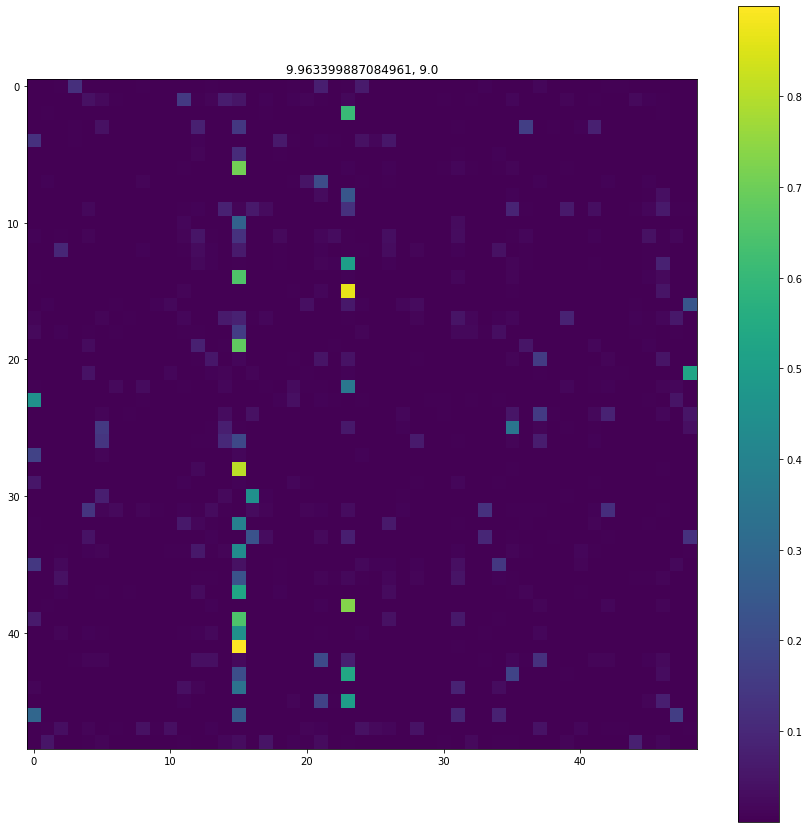

<Figure size 1080x1080 with 0 Axes>

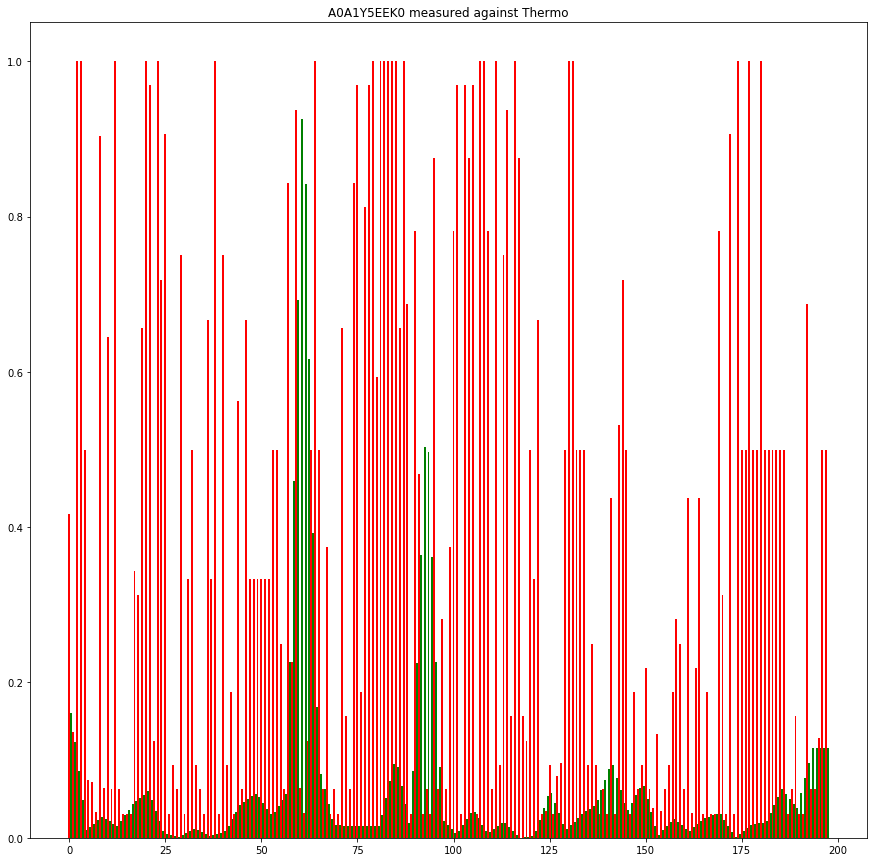

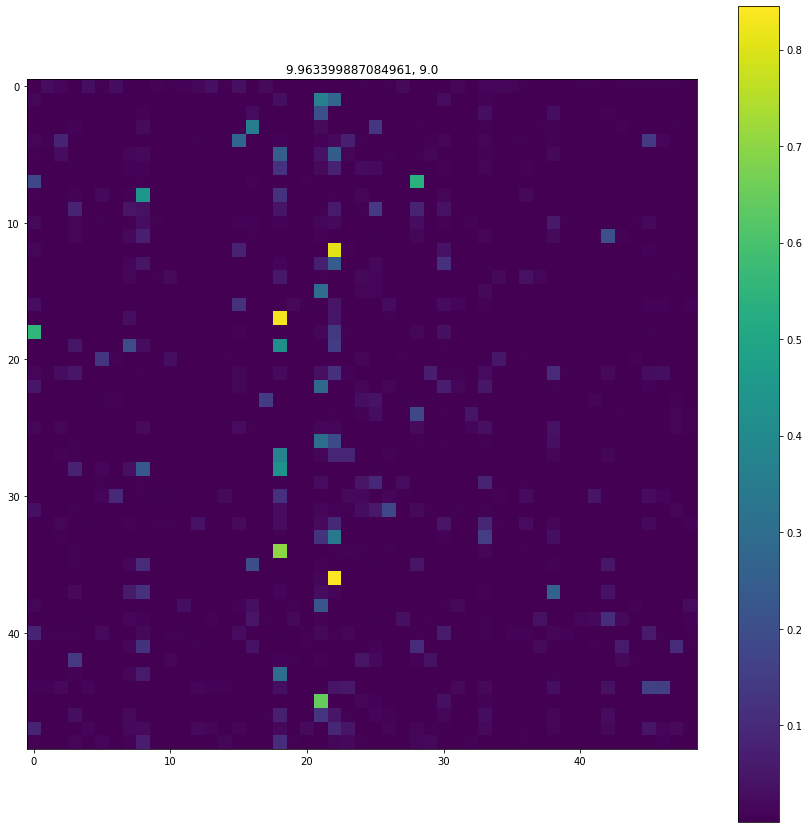

<Figure size 1080x1080 with 0 Axes>

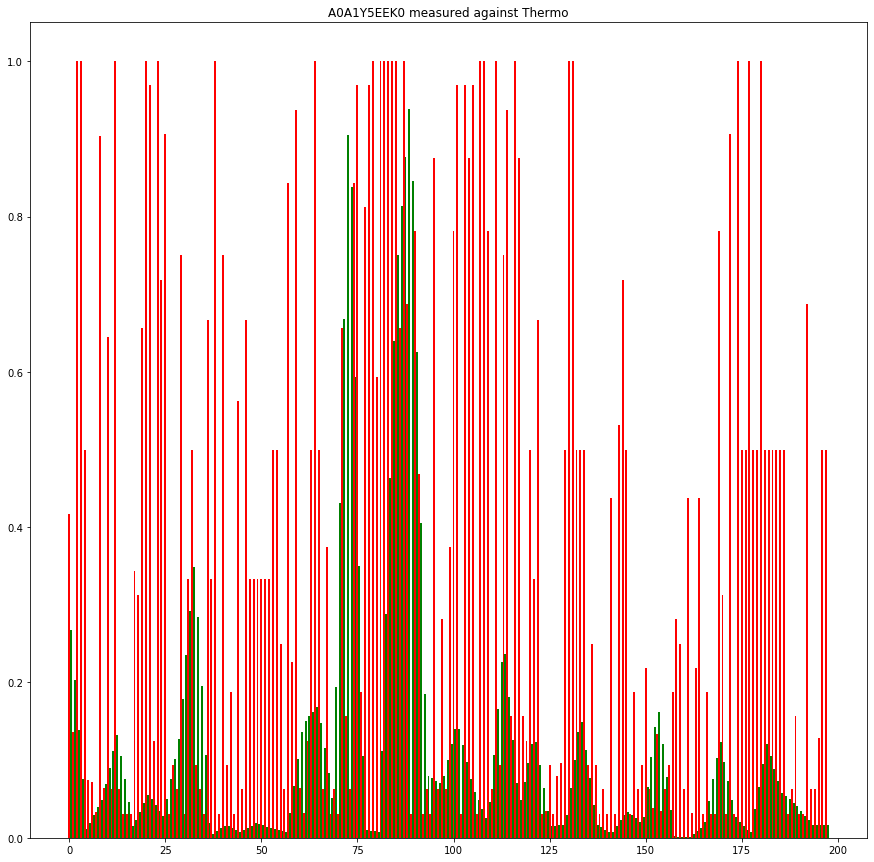

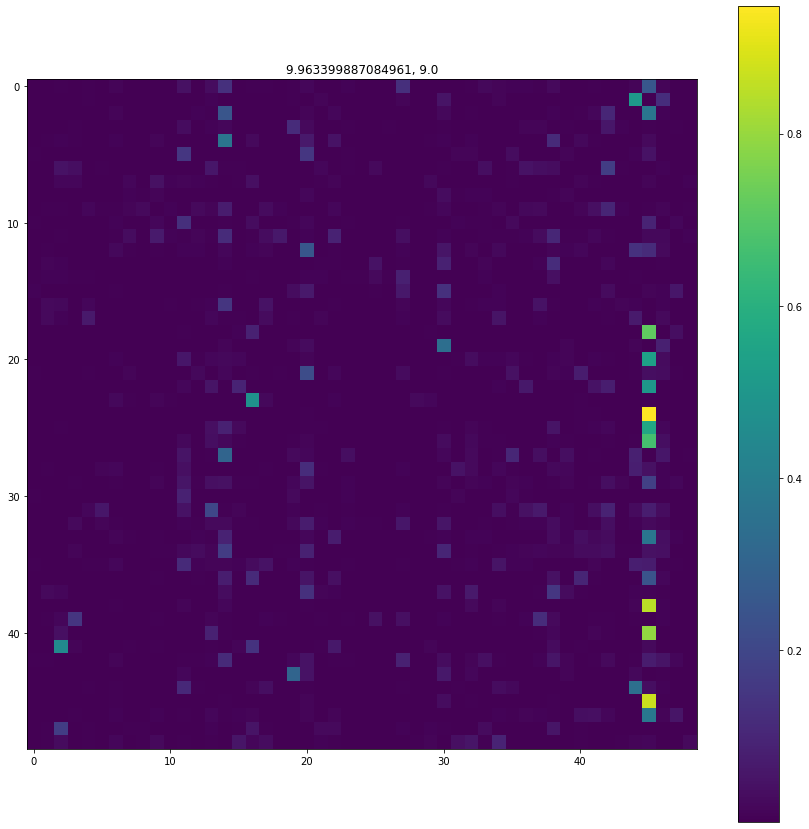

<Figure size 1080x1080 with 0 Axes>

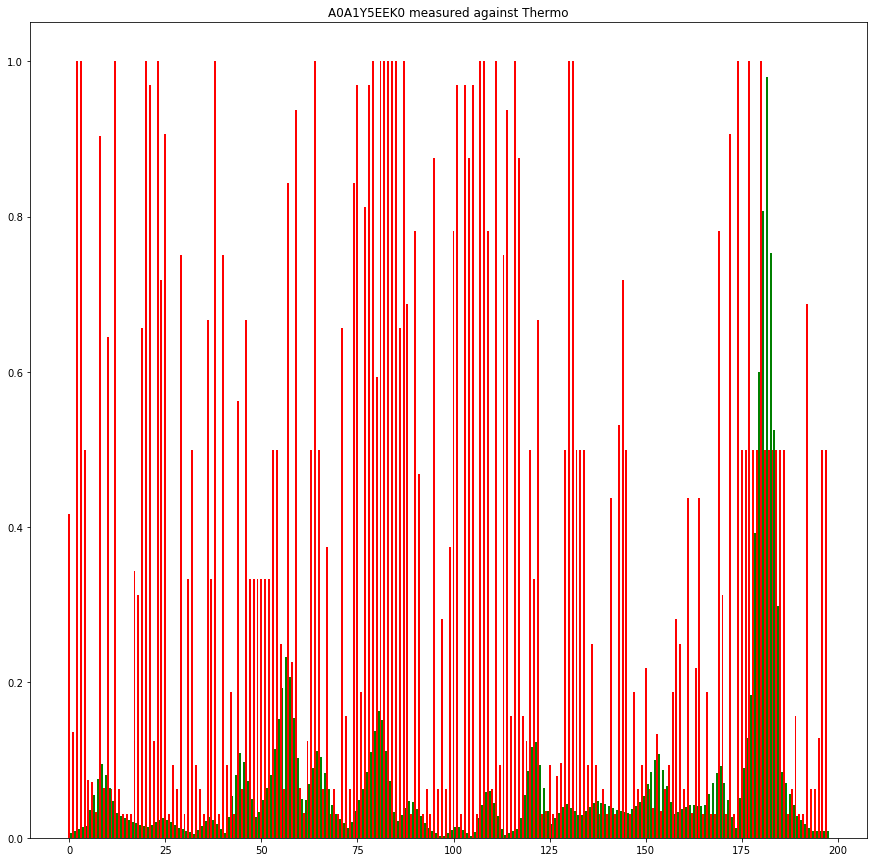

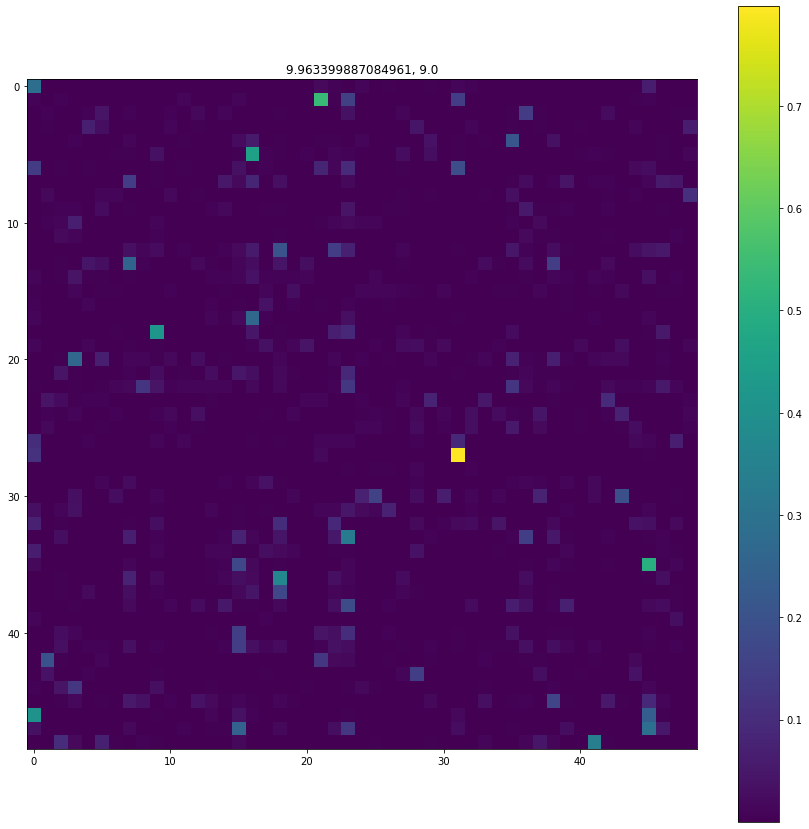

<Figure size 1080x1080 with 0 Axes>

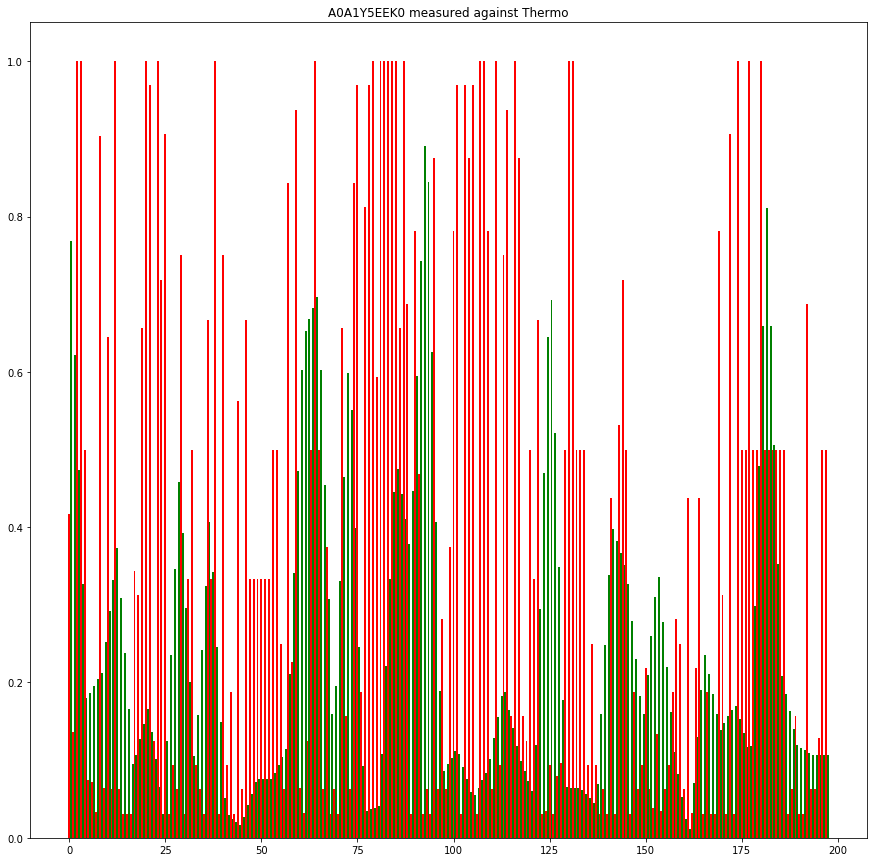

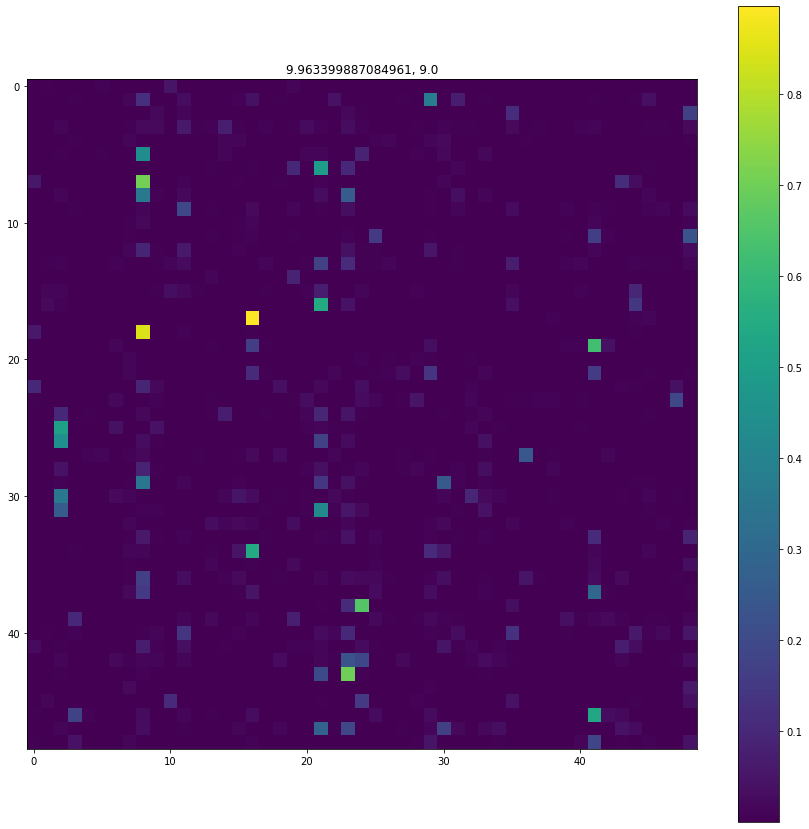

<Figure size 1080x1080 with 0 Axes>

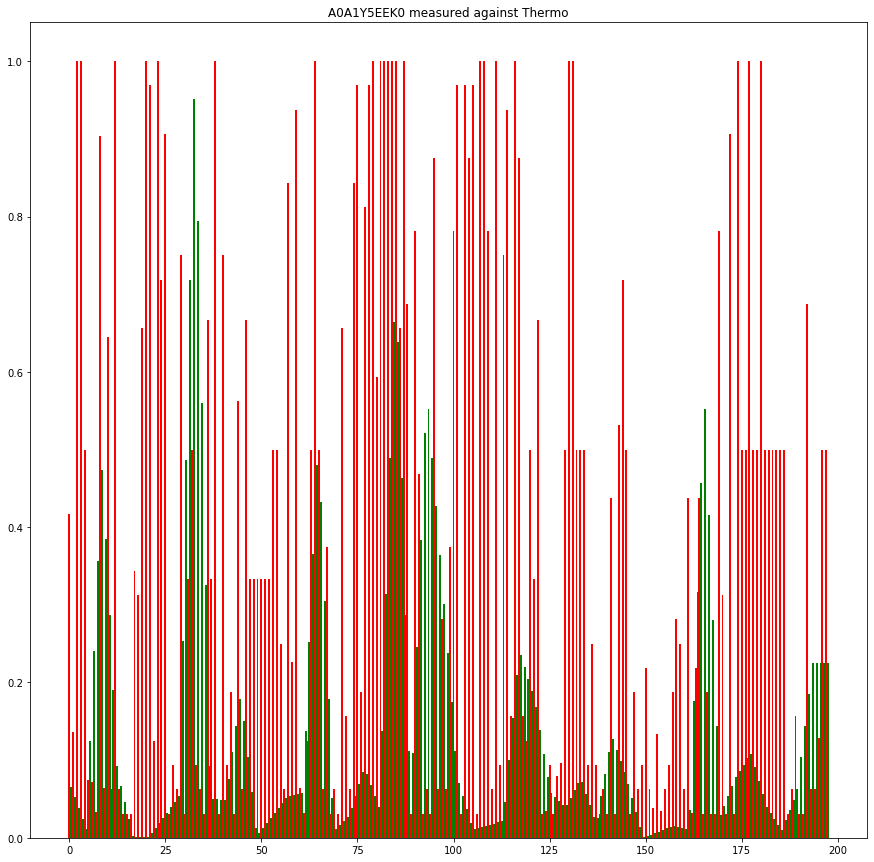

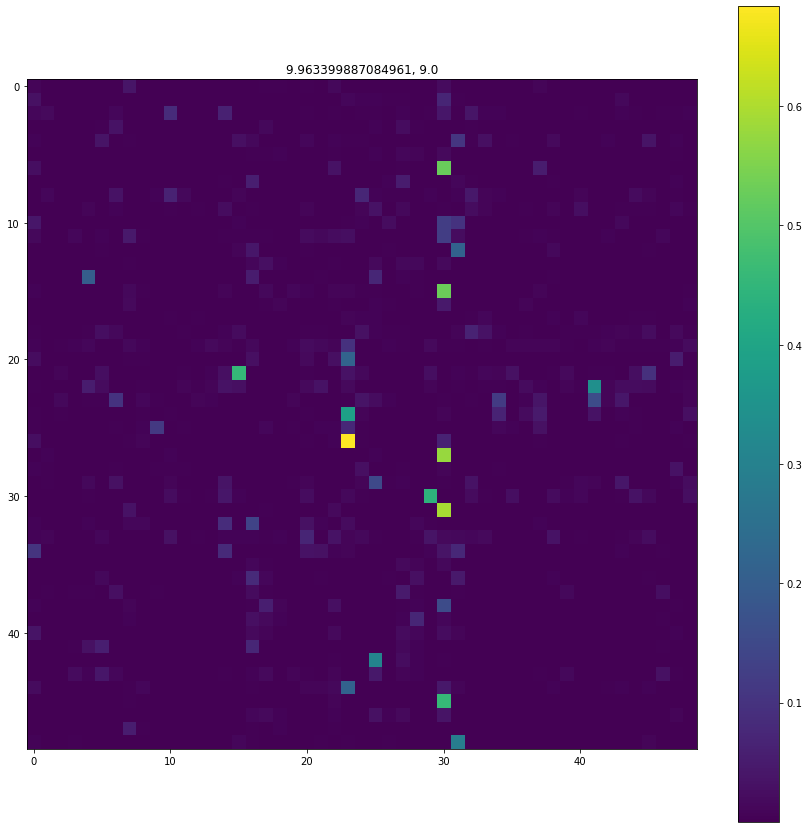

<Figure size 1080x1080 with 0 Axes>

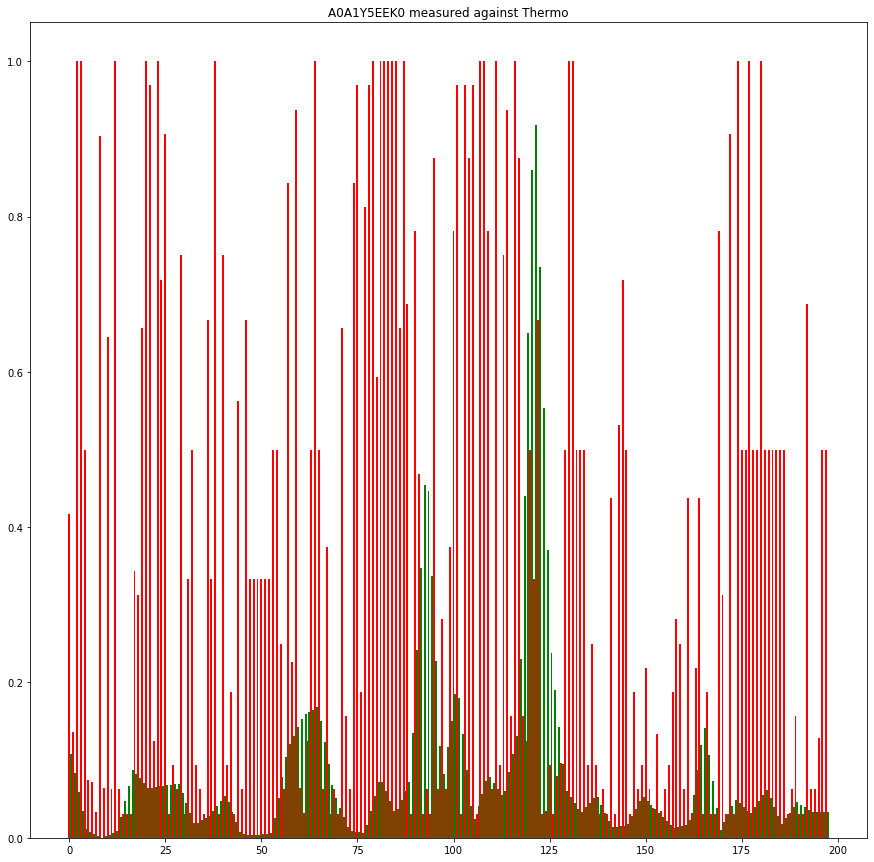

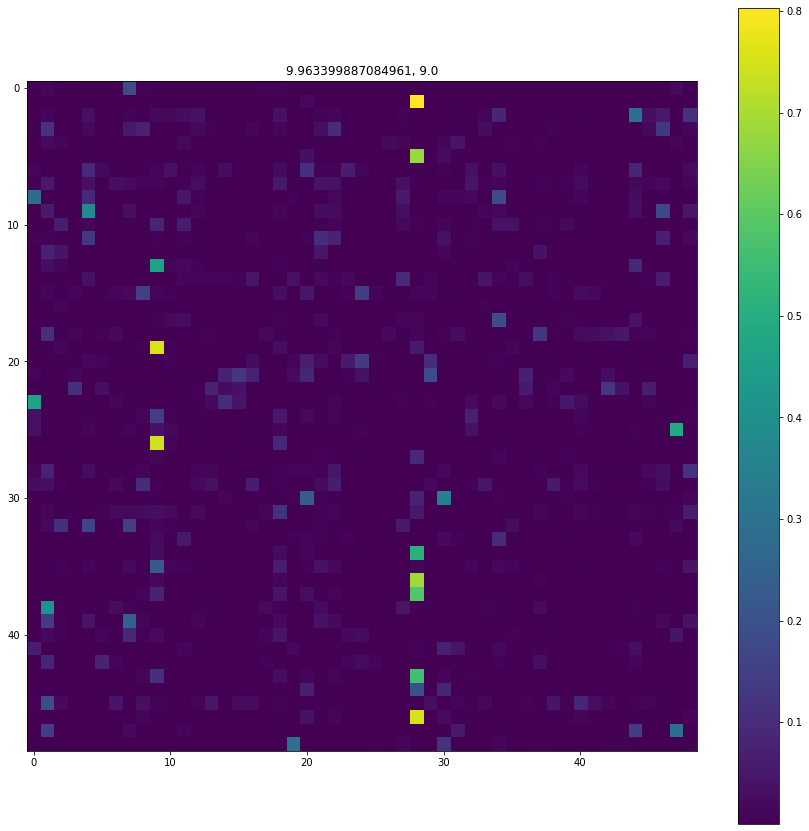

<Figure size 1080x1080 with 0 Axes>

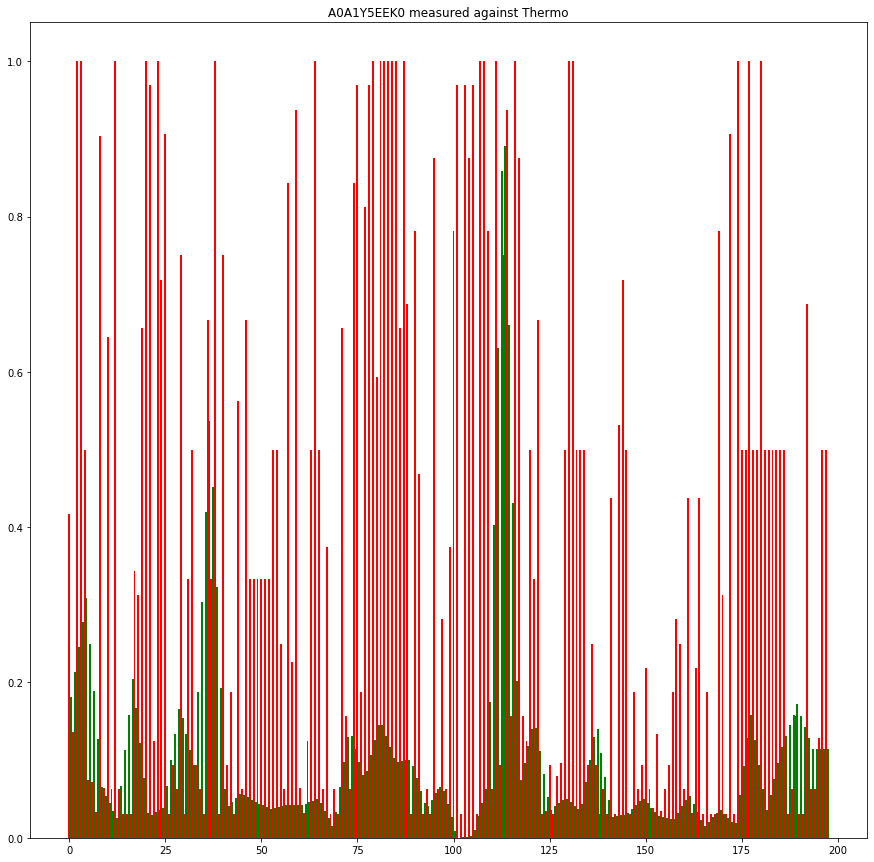

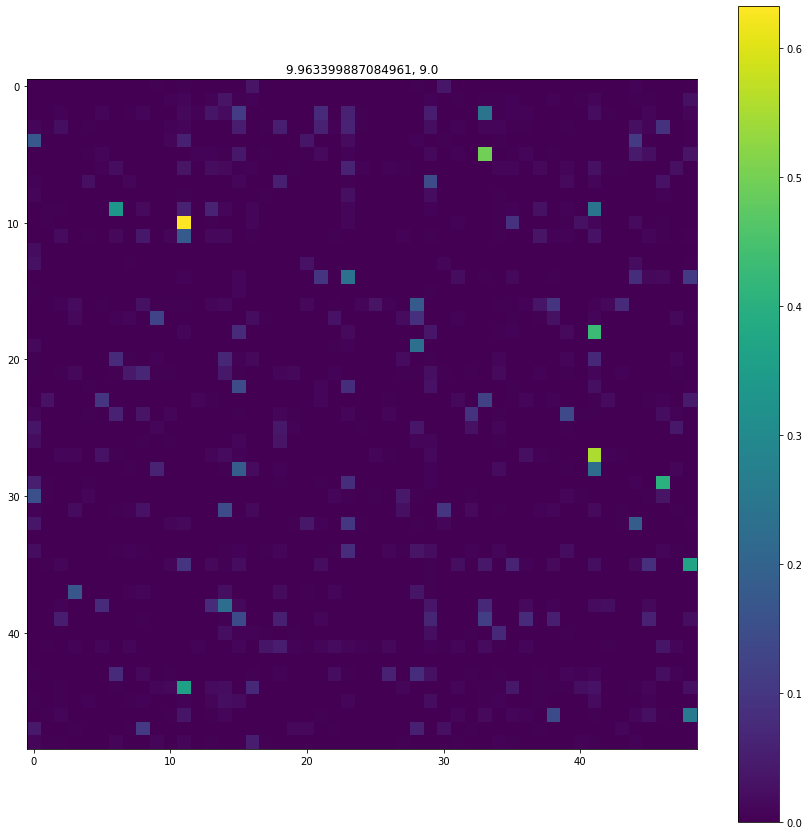

<Figure size 1080x1080 with 0 Axes>

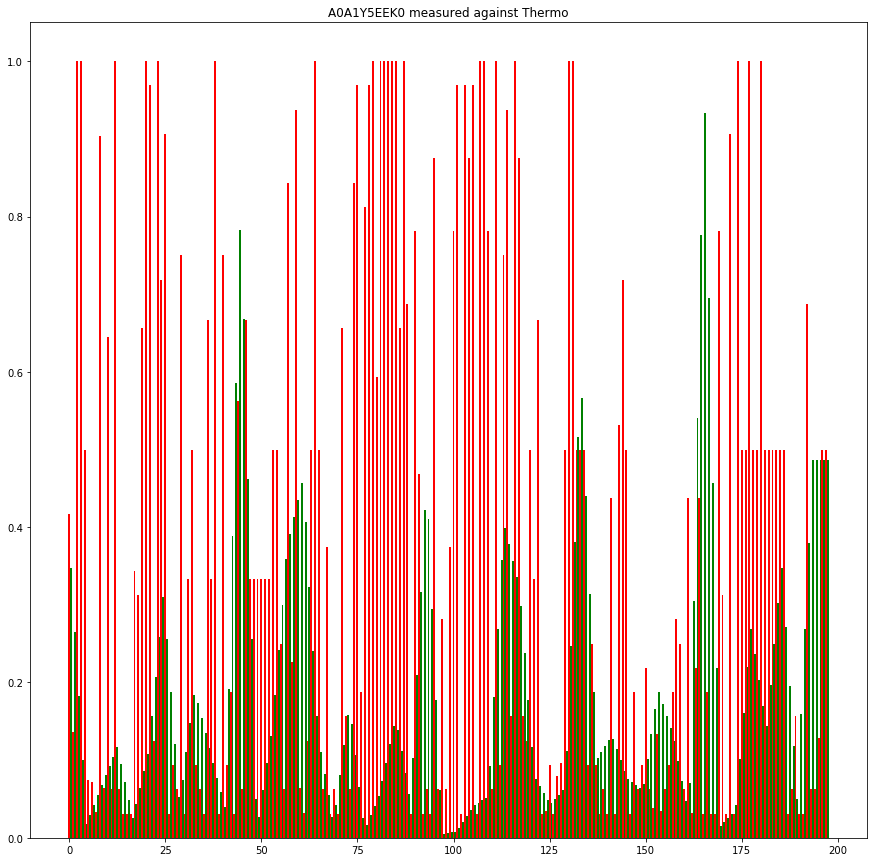

In [32]:

scaled = np.prod(config['Classifier']['strides'][:config['Classifier']['attention_loc']])
n = 0
scaled_length = int(length[n]//scaled)                       
print(length[n])
print(scaled)
print(scaled_length)


name = "COG0066_52.ali"
dicts = import_alignment(name)
dict_name = 'Thermo'
seq_dict = 'All'
seq = dicts[seq_dict]['seq'][n]
id_ = dicts[seq_dict]['id'][n]

index = index_aa(seq)
msa_aa = aa_at_index(index, dicts[dict_name])
prob_per_residue, insertions = residy_entropy(seq, index, msa_aa)
#plot_prob_aa(prob_per_residue, insertions, id_, dict_name)
prob_per_residue, insertions = prob_mutation(seq, index, msa_aa)


for i in range(8):
    plt.figure(figsize=[15,15])
    plt.imshow(attention_weights[n,i,:scaled_length,:scaled_length])
    plt.colorbar()
    plt.title('{}, {}'.format(prediction[n][0] +41.9, x[1][n]+41.9))
    plt.show()
    
    plt.figure(figsize=[15,15])
    mi = np.min( np.sum(attention_weights[n,i,:scaled_length,:scaled_length], axis = 0))
    ma = np.max( np.sum(attention_weights[n,i,:scaled_length,:scaled_length], axis = 0))
    feature = (np.sum(attention_weights[n,i,:scaled_length,:scaled_length], axis = 0)-mi)/ma
    
    line = np.linspace(0,scaled_length,int(length[n]))
    feature_upsample = np.interp(line, np.arange(scaled_length), feature)
    
    
    
    plot_prob_aa_atte(prob_per_residue, insertions, id_, dict_name, length[n],feature_upsample)



In [12]:
x_val = data_val.batch(64, drop_remainder=True)
predictions = ensemble.predict(x_val)

true = np.zeros_like(predictions)
for i, batch in enumerate(x_val):
    true[i*64:i*64+64,0] = batch[1]+ 41.9


predictions += 41.9


In [13]:
diff = predictions - true
print(np.std(diff))

11.124029


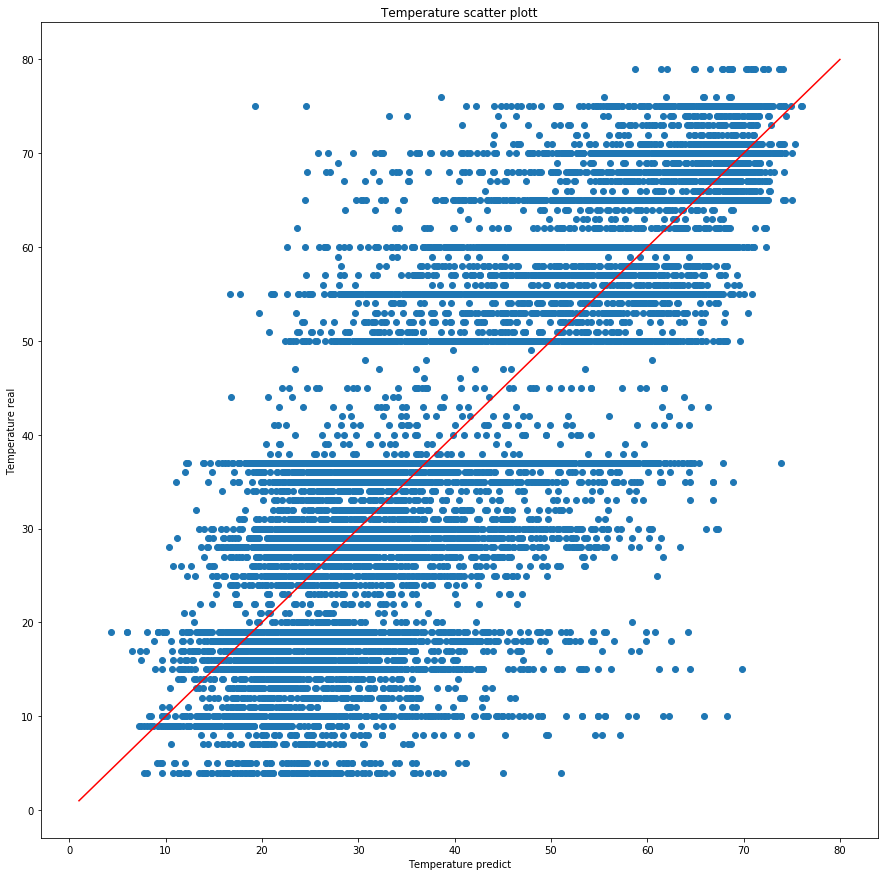

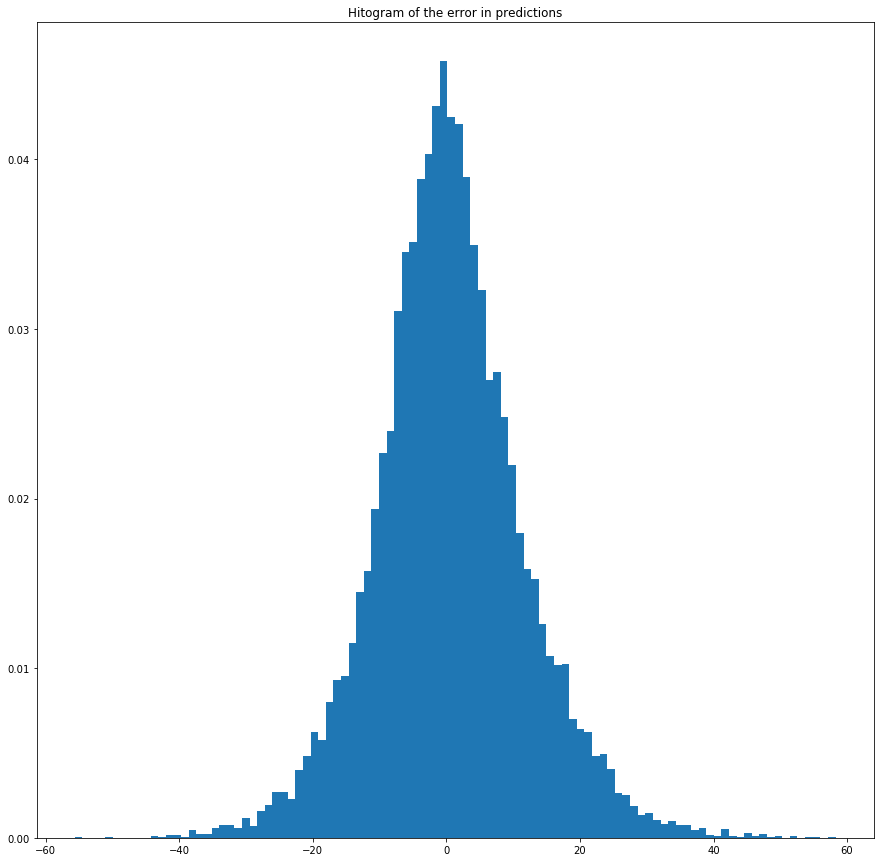

In [14]:
import matplotlib.pyplot as plt
plt.figure(figsize=[15,15])
plt.scatter(predictions, true)
x =[1, 80]
plt.plot(x, x, c = 'r')
plt.title("Temperature scatter plott")
plt.ylabel("Temperature real")
plt.xlabel("Temperature predict")

plt.figure(figsize=[15,15])
plt.hist(diff, bins = 100, density=True)
plt.title("Hitogram of the error in predictions")
plt.show()

In [ ]:
import os
